In [36]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split

# Set the base directory and directories for training and test data
BASE_DIR = 'D:/projects/Winstars/airbus-ship-detection'
TRAIN_DIR = BASE_DIR + '/train_v2/'
TEST_DIR = BASE_DIR + '/test_v2/'

In [37]:
# Get the list of files from the training directory
train = os.listdir(TRAIN_DIR)

# Get the list of files from the test directory
test = os.listdir(TEST_DIR)

# Print the number of train files and the first three filenames
print(f"Train files: {len(train)} ---> {train[:3]}")

# Print the number of test files and the first three filenames
print(f"Test files: {len(test)} ---> {test[:3]}")

Train files: 192556 ---> ['00003e153.jpg', '0001124c7.jpg', '000155de5.jpg']
Test files: 15606 ---> ['00002bd58.jpg', '00015efb6.jpg', '00023d5fc.jpg']


In [38]:
# Specify the path to the CSV file containing ship segmentations
csv_file_path = os.path.join(BASE_DIR, 'train_ship_segmentations_v2.csv')

# Read the CSV file into a pandas DataFrame
masks = pd.read_csv(csv_file_path)

# Filter out rows where 'EncodedPixels' column is not empty
not_empty = pd.notna(masks['EncodedPixels'])

# Count the number of non-empty masks
num_non_empty_masks = not_empty.sum()

# Count the number of unique images with masks
num_unique_images_with_masks = masks[not_empty]['ImageId'].nunique()

# Create a boolean mask for empty images
empty_images = ~not_empty

# Count the number of empty images
num_empty_images = empty_images.sum()

# Count the total number of images
num_total_images = masks['ImageId'].nunique()

# Print the number of masks and images with masks
print(f"{num_non_empty_masks} masks in {num_unique_images_with_masks} images")

# Print the number of empty images and total images
print(f"{num_empty_images} empty images in {num_total_images} total images")
masks.head()

81723 masks in 42556 images
150000 empty images in 192556 total images


,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [39]:
# Add a new column 'ships' to the DataFrame indicating if a row has a mask
masks['ships'] = masks['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)

# Group the DataFrame by 'ImageId' and calculate the sum of 'ships' for each image
unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index()

# Add a new column 'has_ship' indicating if an image has a ship or not
unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x > 0 else 0.0)

# Drop the 'ships' column from the masks DataFrame
masks.drop(['ships'], axis=1, inplace=True)

# Print the first five images with multiple ships
print(unique_img_ids.loc[unique_img_ids['ships'] >= 2].head())

          ImageId  ships  has_ship
3   000194a2d.jpg      5       1.0
5   00021ddc3.jpg      9       1.0
6   0002756f7.jpg      2       1.0
11  000532683.jpg      2       1.0
15  0005d01c8.jpg      2       1.0


<Axes: >

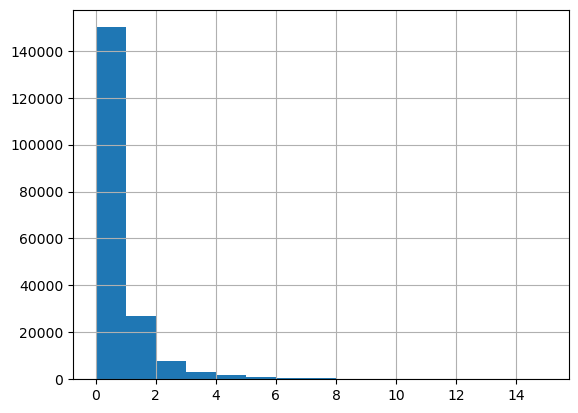

In [40]:
# Plot a histogram of the number of ships per image
unique_img_ids['ships'].hist(bins=unique_img_ids['ships'].max())

In [41]:
# Print the maximum and average number of ships per image
print('Max number of ships:', unique_img_ids['ships'].max())
print('Average number of ships:', unique_img_ids['ships'].mean())

Max number of ships: 15
Average number of ships: 0.4244115997424126


19778 masks


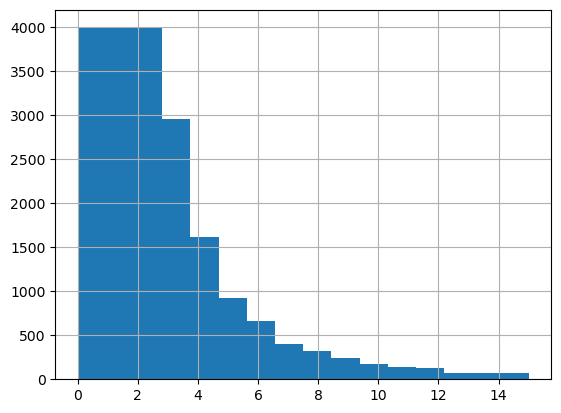

In [42]:
SAMPLES_PER_GROUP = 4000
balanced_train_df = unique_img_ids.groupby('ships').apply(lambda x: x.sample(SAMPLES_PER_GROUP) if len(x) > SAMPLES_PER_GROUP else x)
balanced_train_df['ships'].hist(bins=balanced_train_df['ships'].max()+1)
print(balanced_train_df.shape[0], 'masks')

In [43]:
# Split the DataFrame into training and validation sets
train_ids, valid_ids = train_test_split(unique_img_ids, test_size=0.2, stratify=unique_img_ids['ships'])

# Merge the masks DataFrame with the training set
train_df = pd.merge(masks, train_ids)

# Merge the masks DataFrame with the validation set
valid_df = pd.merge(masks, valid_ids)

# Print the number of training masks
print(train_df.shape[0], 'training masks')

# Print the number of validation masks
print(valid_df.shape[0], 'validation masks')

185382 training masks
46341 validation masks
